In [1]:
import warnings
warnings.filterwarnings('ignore')

### Allocating Dynamic GPU Memory

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

### Importing Libraries and Packages

In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import concatenate
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_absolute_error
import csv
from matplotlib import pyplot
from keras.layers import CuDNNLSTM, merge,ConvLSTM2D, Lambda, Conv2DTranspose, Concatenate, Flatten, Conv2D, BatchNormalization, UpSampling2D, MaxPooling2D, MaxPooling3D, UpSampling3D
from keras import losses
from keras.layers import Input, Reshape
from keras.models import Model
import matplotlib.pyplot as plt
import keras
import pickle
from keras.layers import Bidirectional
import os
import sys
import time
from scipy.spatial import distance
from sklearn.metrics import hamming_loss
import keras.backend as K
import json
from PIL import ImageFilter
import PIL
from keras import regularizers

In [4]:
#loading data
train_image_path = 'train/img'
train_mask_path = 'train/mask'

val_image_path = 'val/img'
val_mask_path = 'val/mask'

test_image_path = 'test/img'
test_mask_path = 'test/mask'

### Fetching Data

In [5]:
def get_data(image_path, mask_path):
    train_images = sorted(os.listdir(image_path))
    mask_images = sorted(os.listdir(mask_path))
    i = 0
    x_nump = []
    y_nump = []
    
    for img in train_images:
        i = i + 1
        per = i / len(train_images) * 100

        x = Image.open(image_path + "/" + img)
        x = x.resize((512,512))
        x = x.convert('L')

        x = np.array(x)
        x = np.expand_dims(x, -1)
        x_nump.append(x)
    
    for img in mask_images:
        i = i + 1
        per = i / len(train_images) * 100
        
        y = Image.open(mask_path + "/" + img)
        y = y.resize((512,512))
        y = y.convert('L')

        y = np.array(y)
        y = np.expand_dims(y, -1)
        
        y_nump.append(y)
        
        
    x_nump = np.array(x_nump)
    y_nump = np.array(y_nump)
    
    y_nump[y_nump == 0] = 0
    y_nump[y_nump != 0] = 1

    return x_nump, y_nump

In [6]:
train_x , train_y = get_data(train_image_path, train_mask_path)
val_x , val_y = get_data(val_image_path, val_mask_path)

In [8]:
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

(374, 512, 512, 1) (374, 512, 512, 1)
(34, 512, 512, 1) (34, 512, 512, 1)


In [10]:
mean = np.mean(train_x)
std = np.std(train_x)
train_x = (train_x - mean) / std
val_x = (val_x - mean) / std

(374, 512, 512, 1)
1


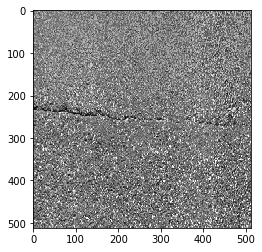

2


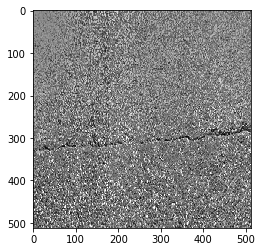

3


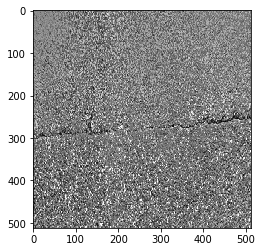

4


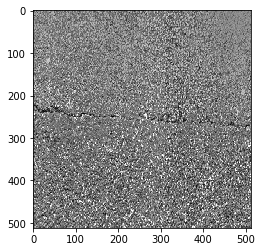

5


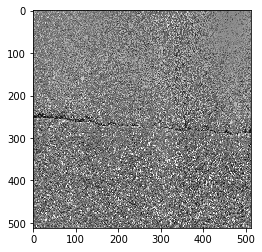

6


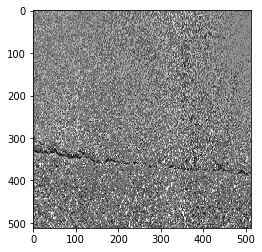

7


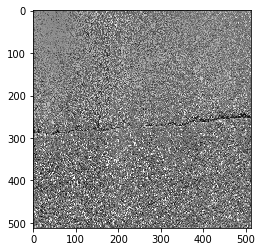

8


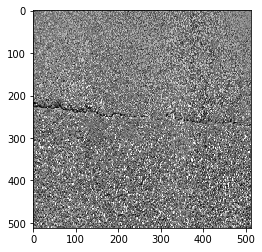

9


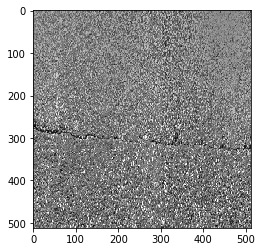

10


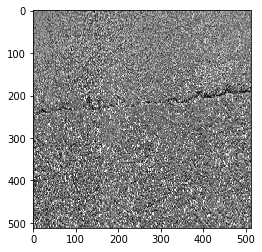

In [12]:
print(train_x.shape)
i = 0
for sequence in range(len(train_x)):
    i = i + 1
    print(i)
    plt.imshow(np.reshape(train_x[sequence], (512,512)), cmap='gray')
    plt.pause(0.005)
    if i == 10:
        break

(374, 512, 512, 1)
1


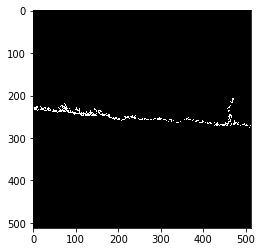

2


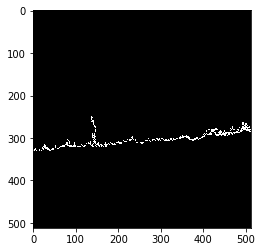

3


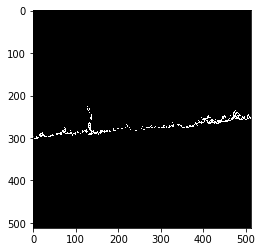

4


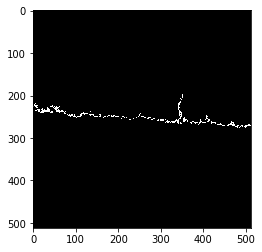

5


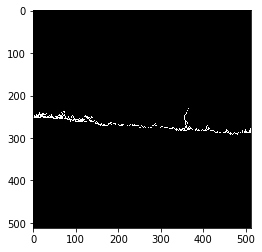

6


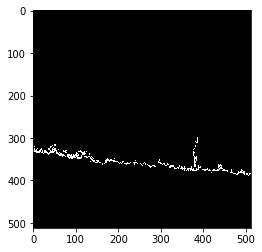

7


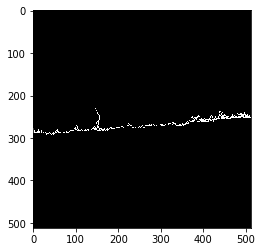

8


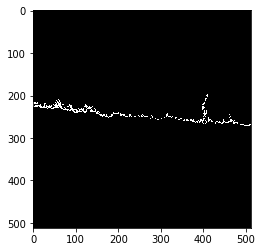

9


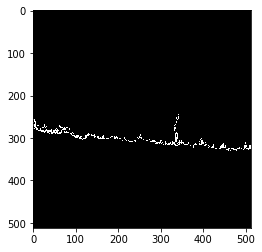

10


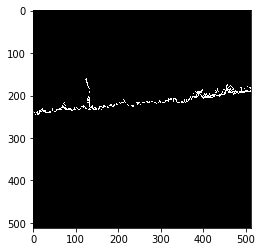

In [13]:
print(train_y.shape)
i = 0
for sequence in range(len(train_y)):
    i = i + 1
    print(i)
    plt.imshow(np.reshape(train_y[sequence], (512,512)), cmap='gray')
    plt.pause(0.005)
    if (i == 10):
        break

In [14]:
#row by row sequence
def stretch_data(x_train, y_train):
    x_sequence = list()
    y_sequence = list()
    
    for img in x_train:
        for row in img:
            x_sequence.append(row)
            
    for img in y_train:
        for row in img:
            y_sequence.append(row)
        
    return np.array(x_sequence), np.array(y_sequence)

In [15]:
x_train_sequence, y_train_sequence = stretch_data(train_x,train_y)
del train_x,train_y
val_x_train_sequence, val_y_train_sequence = stretch_data(val_x,val_y)
del val_x,val_y

In [16]:
print(x_train_sequence.shape , y_train_sequence.shape)
print(val_x_train_sequence.shape , val_y_train_sequence.shape)

(191488, 512, 1) (191488, 512, 1)
(17408, 512, 1) (17408, 512, 1)


In [17]:
def get_sequence(x_train, y_train, time_step, window):
    amount_of_features = x_train.shape[1]
    sequence_length = time_step
    x_result = []
    y_result = []
    
    x_seq_res = []
    y_seq_res = []
    #Dividing the complete image sequence into blocks of shape window x features
    #Image 
    for index in range(0,len(x_train), window):
        x_result.append(x_train[index: index + window])
    #Mask
    for index in range(0,len(y_train), window):
        y_result.append(y_train[index: index + window])
        
    x_result = np.array(x_result)
    y_result = np.array(y_result)   
    print(x_result.shape)
    print(y_result.shape)

    #Making the sequence of shape time_step x window x features
    #Image 
    for index in range(len(x_result) - sequence_length):
        x_seq_res.append(x_result[index: index + sequence_length])
    #Mask
    for index in range(len(y_result) - sequence_length):
        y_seq_res.append(y_result[index + sequence_length - 1])
    
    x_seq_res = np.array(x_seq_res)
    y_seq_res = np.array(y_seq_res)
    print(x_seq_res.shape, y_seq_res.shape)
    
    return [x_seq_res, y_seq_res]

In [18]:
x_train, y_train = get_sequence(x_train_sequence, y_train_sequence, 8, 1)
del x_train_sequence, y_train_sequence
val_x_train, val_y_train = get_sequence(val_x_train_sequence, val_y_train_sequence, 8, 1)
del val_x_train_sequence, val_y_train_sequence

(191488, 1, 512, 1)
(191488, 1, 512, 1)
(191480, 8, 1, 512, 1) (191480, 1, 512, 1)
(17408, 1, 512, 1)
(17408, 1, 512, 1)
(17400, 8, 1, 512, 1) (17400, 1, 512, 1)


In [21]:
def mean_iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true)+K.sum(y_pred)-intersection
    iou = ((intersection) / (union + K.epsilon()))
    return iou

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    # some implementations don't square y_pred
    denominator = tf.reduce_sum(y_true + tf.square(y_pred))

    return numerator / (denominator + tf.keras.backend.epsilon())

In [22]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = ((2. * intersection)/(union + K.epsilon()))
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [25]:
def binary_focal_loss_fixed(y_true, y_pred, smooth = 1.0):
    
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.zeros_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    
    intersection = K.sum(pt_1)
    false_negative = K.sum(pt_0) 
    
    union = K.sum(y_true) + K.sum(y_pred)
    dice = ((2. * intersection)/(union + K.epsilon()))
    
    return (1-dice)

In [26]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(y_true * y_pred)
    possible_positives = K.sum(y_true)
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(y_true * y_pred)
    predicted_positives = K.sum(y_pred)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [27]:
def loss(y_true, y_pred):
    return 1 - f1_m(y_true, y_pred)

### Defining Architecture

In [34]:
def get_model(pretrained_weights = None,input_size = (8, 1, 512, 1)):
    inputs = Input(input_size)
    
    conv1 = (ConvLSTM2D(64, kernel_size=(1,9), activation = 'tanh', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2', return_sequences=True))(inputs)
    bnorm1 = BatchNormalization()(conv1)
    drop1 = Dropout(0.4)(bnorm1)
    conv5 = ConvLSTM2D(1, kernel_size=(1,9), activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer='l2', return_sequences=False)(drop1)
    
    #Model                     
    model = Model(input = inputs, output = conv5)
    
    model.compile(optimizer = keras.optimizers.Adam(lr = 1e-4), loss = binary_focal_loss_fixed , metrics = ['accuracy', dice_coef, mean_iou])
    
    if(pretrained_weights):
        print('loading_weights')
        model.load_weights(pretrained_weights)

    return model

In [35]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 8, 1, 512, 1)      0         
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 8, 1, 512, 64)     150016    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 1, 512, 64)     256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 1, 512, 64)     0         
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 1, 512, 1)         2344      
Total params: 152,616
Trainable params: 152,488
Non-trainable params: 128
_________________________________________________________________


### Training the model

In [36]:
model = get_model()
model_checkpoint = keras.callbacks.ModelCheckpoint('augmented_50_50_random_split_AEL_grayscale_input_2_layer_tanh_softmax_loss_f1_epochs_100_bs_256_lr_1e_4_input_8_1_512.hdf5', monitor='val_f1_m', mode='max', verbose=1, save_best_only=True)
history = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(val_x_train, val_y_train), verbose=1, callbacks=[model_checkpoint])

with open('augmented_50_50_random_split_AEL_grayscale_input_2_layer_tanh_softmax_loss_f1_epochs_100_bs_320_lr_1e_4_input_8_1_480.json', 'w') as f:
    json.dump(history.history, f)

Train on 191480 samples, validate on 17400 samples
Epoch 1/100
191480/191480 [==============================] - 687s 4ms/step - loss: 4.0096 - acc: 0.9425 - dice_coef: 0.3973 - mean_iou: 0.2573 - val_loss: 3.6427 - val_acc: 0.9933 - val_dice_coef: 0.2879 - val_mean_iou: 0.2016
Epoch 2/100
191480/191480 [==============================] - 688s 4ms/step - loss: 3.0574 - acc: 0.9929 - dice_coef: 0.4921 - mean_iou: 0.3276 - val_loss: 2.8896 - val_acc: 0.9933 - val_dice_coef: 0.3135 - val_mean_iou: 0.2218
Epoch 3/100
191480/191480 [==============================] - 688s 4ms/step - loss: 2.4112 - acc: 0.9931 - dice_coef: 0.5064 - mean_iou: 0.3404 - val_loss: 2.3317 - val_acc: 0.9927 - val_dice_coef: 0.3245 - val_mean_iou: 0.2296
Epoch 4/100
191480/191480 [==============================] - 688s 4ms/step - loss: 1.9219 - acc: 0.9932 - dice_coef: 0.5168 - mean_iou: 0.3496 - val_loss: 1.9159 - val_acc: 0.9935 - val_dice_coef: 0.3241 - val_mean_iou: 0.2313
Epoch 5/100
191480/191480 [==============

Epoch 37/100
191480/191480 [==============================] - 672s 4ms/step - loss: 0.4873 - acc: 0.9938 - dice_coef: 0.5652 - mean_iou: 0.3950 - val_loss: 0.6909 - val_acc: 0.9940 - val_dice_coef: 0.3609 - val_mean_iou: 0.2607
Epoch 38/100
191480/191480 [==============================] - 673s 4ms/step - loss: 0.4860 - acc: 0.9938 - dice_coef: 0.5652 - mean_iou: 0.3952 - val_loss: 0.6819 - val_acc: 0.9938 - val_dice_coef: 0.3688 - val_mean_iou: 0.2676
Epoch 39/100
191480/191480 [==============================] - 673s 4ms/step - loss: 0.4832 - acc: 0.9939 - dice_coef: 0.5669 - mean_iou: 0.3968 - val_loss: 0.6861 - val_acc: 0.9943 - val_dice_coef: 0.3635 - val_mean_iou: 0.2640
Epoch 40/100
191480/191480 [==============================] - 673s 4ms/step - loss: 0.4827 - acc: 0.9938 - dice_coef: 0.5663 - mean_iou: 0.3962 - val_loss: 0.6829 - val_acc: 0.9935 - val_dice_coef: 0.3657 - val_mean_iou: 0.2644
Epoch 41/100
191480/191480 [==============================] - 673s 4ms/step - loss: 0.47

191480/191480 [==============================] - 672s 4ms/step - loss: 0.4403 - acc: 0.9942 - dice_coef: 0.5887 - mean_iou: 0.4183 - val_loss: 0.6507 - val_acc: 0.9942 - val_dice_coef: 0.3782 - val_mean_iou: 0.2762
Epoch 76/100
191480/191480 [==============================] - 673s 4ms/step - loss: 0.4399 - acc: 0.9942 - dice_coef: 0.5889 - mean_iou: 0.4184 - val_loss: 0.6474 - val_acc: 0.9936 - val_dice_coef: 0.3812 - val_mean_iou: 0.2770
Epoch 77/100
191480/191480 [==============================] - 673s 4ms/step - loss: 0.4389 - acc: 0.9942 - dice_coef: 0.5895 - mean_iou: 0.4192 - val_loss: 0.6569 - val_acc: 0.9945 - val_dice_coef: 0.3715 - val_mean_iou: 0.2717
Epoch 78/100
191480/191480 [==============================] - 673s 4ms/step - loss: 0.4380 - acc: 0.9942 - dice_coef: 0.5903 - mean_iou: 0.4198 - val_loss: 0.6574 - val_acc: 0.9945 - val_dice_coef: 0.3707 - val_mean_iou: 0.2710
Epoch 79/100
191480/191480 [==============================] - 673s 4ms/step - loss: 0.4371 - acc: 0.9

Epoch 95/100
191480/191480 [==============================] - 677s 4ms/step - loss: 0.4253 - acc: 0.9943 - dice_coef: 0.5993 - mean_iou: 0.4290 - val_loss: 0.6431 - val_acc: 0.9945 - val_dice_coef: 0.3814 - val_mean_iou: 0.2799
Epoch 96/100
191480/191480 [==============================] - 677s 4ms/step - loss: 0.4252 - acc: 0.9943 - dice_coef: 0.5992 - mean_iou: 0.4289 - val_loss: 0.6391 - val_acc: 0.9944 - val_dice_coef: 0.3852 - val_mean_iou: 0.2822
Epoch 97/100
191480/191480 [==============================] - 677s 4ms/step - loss: 0.4248 - acc: 0.9943 - dice_coef: 0.5995 - mean_iou: 0.4293 - val_loss: 0.6439 - val_acc: 0.9944 - val_dice_coef: 0.3803 - val_mean_iou: 0.2782
Epoch 98/100
191480/191480 [==============================] - 677s 4ms/step - loss: 0.4230 - acc: 0.9944 - dice_coef: 0.6011 - mean_iou: 0.4309 - val_loss: 0.6360 - val_acc: 0.9944 - val_dice_coef: 0.3880 - val_mean_iou: 0.2855
Epoch 99/100
191480/191480 [==============================] - 677s 4ms/step - loss: 0.42

In [32]:
model = get_model('augmented_50_50_random_split_AEL_grayscale_input_2_layer_tanh_softmax_loss_f1_epochs_100_bs_320_lr_1e_4_input_8_1_480.hdf5')

loading_weights


In [34]:
model.metrics_names

['loss', 'acc', 'dice_coef', 'mean_iou', 'f1_m']

In [33]:
score = model.evaluate(x_train[], y_train[], batch_size=320)
print(model.metrics_names, score)

3200/3200 [==============================] - 8s 3ms/step
['loss', 'acc', 'dice_coef', 'mean_iou', 'f1_m'] [0.29323542714118955, 0.9909256815910339, 0.17040349915623665, 0.1449022635817528, 0.7067645430564881]


In [34]:
score = model.evaluate(val_x_train[], val_y_train[])
print(model.metrics_names, score)

3200/3200 [==============================] - 9s 3ms/step
['loss', 'acc', 'dice_coef', 'mean_iou', 'f1_m'] [0.7479086345434189, 0.9864307010173797, 0.19798532200977206, 0.16100993164815008, 0.25209136587567627]


In [37]:
time1 = time.time()
y_pred = model.predict(x_train[])
time2 = time.time()
print('{:s} function took {:.3f} ms', (time2-time1))

{:s} function took {:.3f} ms 8.36430048942566


In [38]:
print(np.unique(y_pred, return_counts=True))

(array([0.0000000e+00, 3.5524368e-05, 1.8024445e-04, ..., 9.9862313e-01,
       9.9890220e-01, 1.0000000e+00], dtype=float32), array([1507985,       1,       1, ...,       1,       1,   24854]))


(3200, 1, 480, 1)
(3200, 1, 480, 1)
1


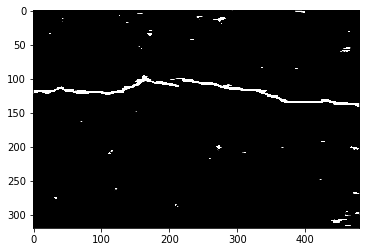

2


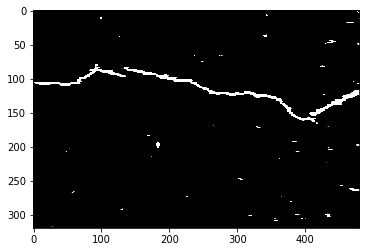

3


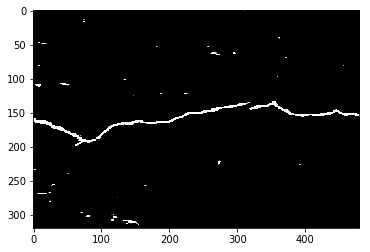

4


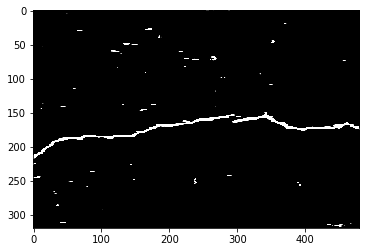

5


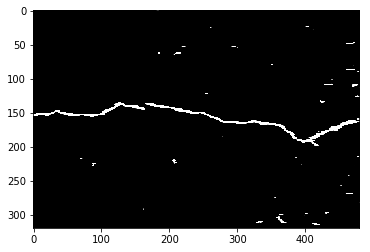

6


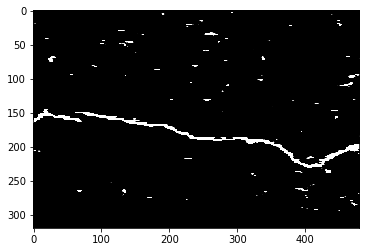

7


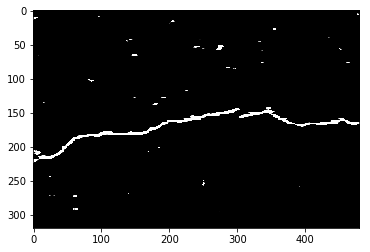

8


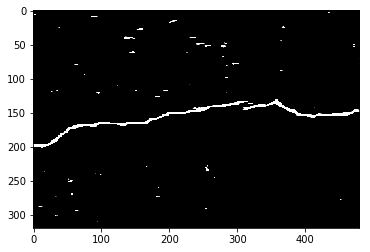

9


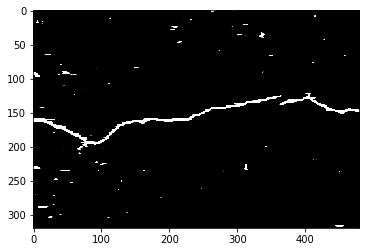

10


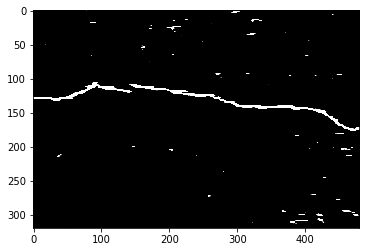

In [39]:
print(y_pred.shape)
print(y_pred.shape)
temp_y = np.reshape(y_pred, (374, 320, 480))
i = 0
for sequence in range(len(temp_y)):
    i+=1
    print(i)
    plt.imshow(temp_y[sequence], cmap='gray')
    plt.pause(0.005)

(207672, 1, 480, 1)
1


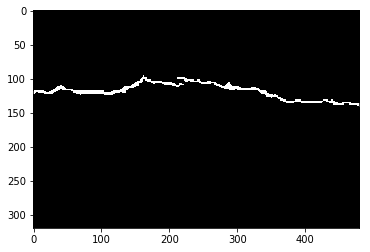

2


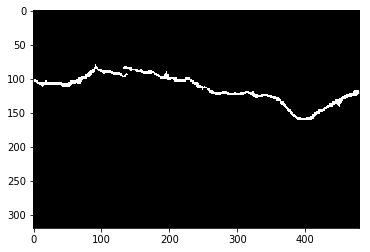

3


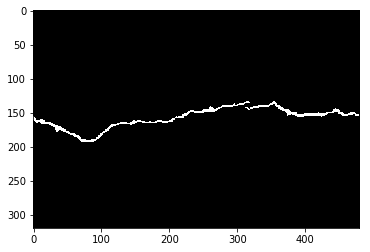

4


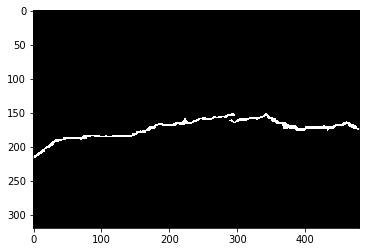

5


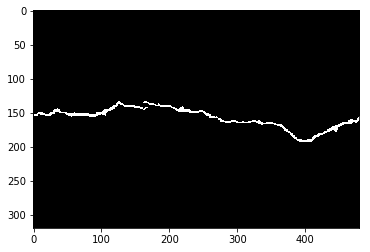

6


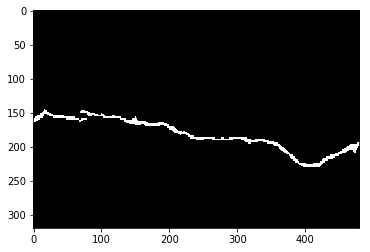

7


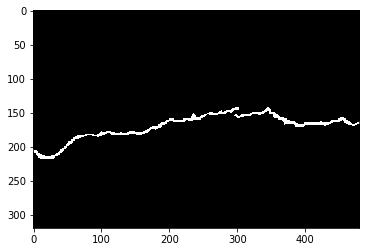

8


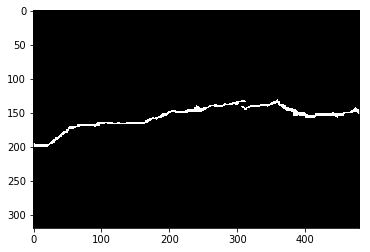

9


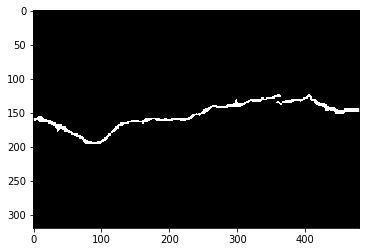

10


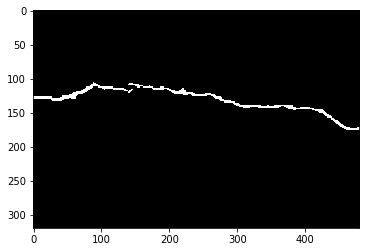

In [40]:
print(y_train.shape)
temp_y = np.reshape(y_train, (374, 320, 480))
i = 0
for sequence in range(len(temp_y)):
    i+=1
    print(i)
    plt.imshow(temp_y[sequence], cmap='gray')
    plt.pause(0.005)

In [41]:
def concat_img(data):
    frames = list()
    row_len = 320
    for rows in range(0,len(data), row_len):
        frames.append(data[rows:rows+row_len])
    frames = np.array(frames)
    return frames

In [42]:
frames_img = concat_img(y_pred)
print(frames_img.shape)

(10, 320, 1, 480, 1)


In [44]:
y_frames_img = concat_img(y_train[])
print(y_frames_img.shape)

(10, 320, 1, 480, 1)


In [45]:
frames_img = np.reshape(frames_img, (374,320,480))
y_frames_img = np.reshape(y_frames_img, (374,320,480))

In [46]:
def recall_m(y_true, y_pred):
    true_positives = np.sum(np.multiply(y_true ,y_pred))
    possible_positives = np.sum(y_true)
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = np.sum(np.multiply(y_true ,y_pred))
    predicted_positives = np.sum(y_pred)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall + K.epsilon()))

In [47]:
recall_scores = list()
for frames in range(len(frames_img)):
    recall_scores.append(recall_m(y_frames_img[frames],frames_img[frames]))
recall_scores = np.array(recall_scores)
print(np.mean(recall_scores))

0.7960533974275598


In [48]:
prec_scores = list()
for frames in range(len(frames_img)):
    prec_scores.append(precision_m(y_frames_img[frames],frames_img[frames]))
prec_scores = np.array(prec_scores)
print(np.mean(prec_scores))

0.6362297164567688


In [49]:
f1_scores = list()
for frames in range(len(frames_img)):
    f1_scores.append(f1_m(y_frames_img[frames],frames_img[frames]))
f1_scores = np.array(f1_scores)
print(np.mean(f1_scores))

0.7067645765485878


In [68]:
def dice_score(y_true, y_pred, smooth=1):   
    intersection = np.sum(np.multiply(y_true ,y_pred))
    union = np.sum(y_true) + np.sum(y_pred)
    iou = (2. * intersection) / (union + K.epsilon())
#     print(iou)
    return iou

In [69]:
dice_scores = list()
for frames in range(len(frames_img)):
    dice_scores.append(dice_score(y_frames_img[frames],frames_img[frames]))
dice_scores = np.array(dice_scores)
print(np.mean(dice_scores))

0.7067646259038873


In [50]:
def iou(y_true, y_pred, smooth=1):   
    intersection = np.sum(np.multiply(y_true ,y_pred))
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = (intersection) / (union + K.epsilon())
#     print(iou)
    return iou

In [51]:
iou_scores = list()
for frames in range(len(frames_img)):
    iou_scores.append(iou(y_frames_img[frames],frames_img[frames]))
iou_scores = np.array(iou_scores)
print(np.mean(iou_scores))

0.2971806840444188
